In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, unix_timestamp, from_unixtime
from pyspark.sql import functions as F
from pyspark import SparkFiles

# let's begin by creating the spark context
# we can reuse this later
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local) created by __init__ at /tmp/ipykernel_68/604461001.py:10 

In [11]:
import matplotlib.pyplot as plt
import json
import requests
import sys
import zipfile
from pyspark.sql import SparkSession
from pyspark.sql.functions import unix_timestamp, col, date_format, to_date
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, FloatType, TimestampType, BooleanType

# only used this locally
# spark = SparkSession.builder \
#     .appName("local") \
#     .config("spark.executor.memory", "4g") \
#     .config("spark.executor.cores", "4") \
#     .getOrCreate()

# schemas for the two datasets
crime_schema = StructType([
    StructField("ID", StringType(), True),
    StructField("Case Number", StringType(), True),
    StructField("Date", StringType(), True),
    StructField("Block", StringType(), True),
    StructField("IUCR", StringType(), True),
    StructField("Primary Type", StringType(), True),
    StructField("Description", StringType(), True),
    StructField("Location Description", StringType(), True),
    StructField("Arrest", BooleanType(), True),
    StructField("Domestic", BooleanType(), True),
    StructField("Beat", IntegerType(), True),
    StructField("District", IntegerType(), True),
    StructField("Ward", IntegerType(), True),
    StructField("Community Area", IntegerType(), True),
    StructField("FBI Code", StringType(), True),
    StructField("X Coordinate", IntegerType(), True),
    StructField("Y Coordinate", IntegerType(), True),
    StructField("Year", IntegerType(), True),
    StructField("Updated On", StringType(), True),
    StructField("Latitude", DoubleType(), True),
    StructField("Longitude", DoubleType(), True),
    StructField("Location", StringType(), True)
])

weather_schema = StructType([
    StructField("name", StringType(), True),
    StructField("datetime", StringType(), True),
    StructField("tempmax", DoubleType(), True),
    StructField("tempmin", DoubleType(), True),
    StructField("temp", DoubleType(), True),
    StructField("feelslikemax", DoubleType(), True),
    StructField("feelslikemin", DoubleType(), True),
    StructField("feelslike", DoubleType(), True),
    StructField("dew", DoubleType(), True),
    StructField("humidity", DoubleType(), True),
    StructField("precip", DoubleType(), True),
    StructField("precipprob", DoubleType(), True),
    StructField("precipcover", DoubleType(), True),
    StructField("preciptype", StringType(), True),
    StructField("snow", DoubleType(), True),
    StructField("snowdepth", DoubleType(), True),
    StructField("windgust", DoubleType(), True),
    StructField("windspeed", DoubleType(), True),
    StructField("winddir", DoubleType(), True),
    StructField("sealevelpressure", DoubleType(), True),
    StructField("cloudcover", DoubleType(), True),
    StructField("visibility", DoubleType(), True),
    StructField("solarradiation", DoubleType(), True),
    StructField("solarenergy", DoubleType(), True),
    StructField("uvindex", IntegerType(), True),
    StructField("severerisk", IntegerType(), True),
    StructField("sunrise", StringType(), True),
    StructField("sunset", StringType(), True),
    StructField("moonphase", DoubleType(), True),
    StructField("conditions", StringType(), True),
    StructField("description", StringType(), True),
    StructField("icon", StringType(), True),
    StructField("stations", StringType(), True)
])


# load csv files
crime_data = spark.read.csv("crimes_2020_onwards.csv", header=True, schema=crime_schema)
weather_data = spark.read.csv("weather_2020_onwards.csv", header=True, schema=weather_schema)

# let's check what we loaded
crime_data.show(5)
print(crime_data.count())
weather_data.show(5)
print(weather_data.count())

# sort out the dates
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")
crime_data = crime_data.withColumn("Date", to_date(unix_timestamp(col("Date"), "MM/dd/yyyy hh:mm:ss aa").cast(TimestampType())))
weather_data = weather_data.withColumn("datetime", to_date(unix_timestamp(col("datetime"), "yyyy-MM-dd").cast(TimestampType())))


# join the data
joined_data = crime_data.join(weather_data, crime_data["Date"] == weather_data["datetime"], "left")
# remove those reports that somehow ended up without temperature
joined_data = joined_data.filter(joined_data["temp"].isNotNull())

# remove most columns that we don't really need for the upcoming analysis
columns_to_keep = ["Date", "Primary Type", "Year", "Latitude", "Longitude", "datetime", "tempmax", "temp", "humidity", "precip", "preciptype", "snow", "snowdepth"]
joined_data = joined_data.select(columns_to_keep)

# let's see the joined data
joined_data.show(5)

+--------+-----------+--------------------+--------------------+----+-------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|                Date|               Block|IUCR|       Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+--------------------+--------------------+----+-------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|13458356|   JH260898|05/12/2024 12:00:...|   018XX W DEVON AVE|0910|MOTOR VEHICLE THEFT|          AUTOMOBILE|         GAS STAT

-21.0
32.5


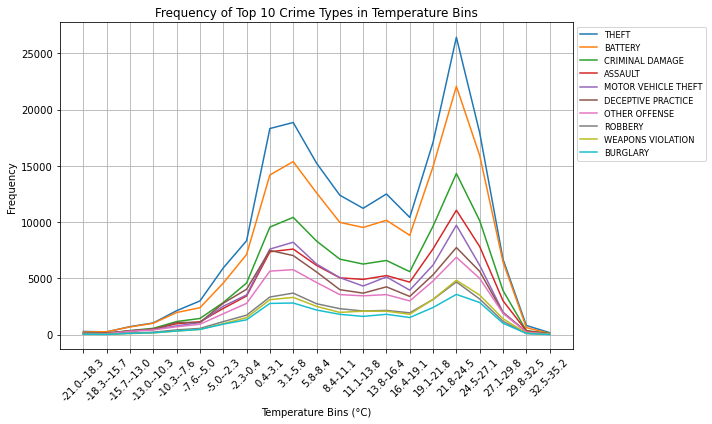

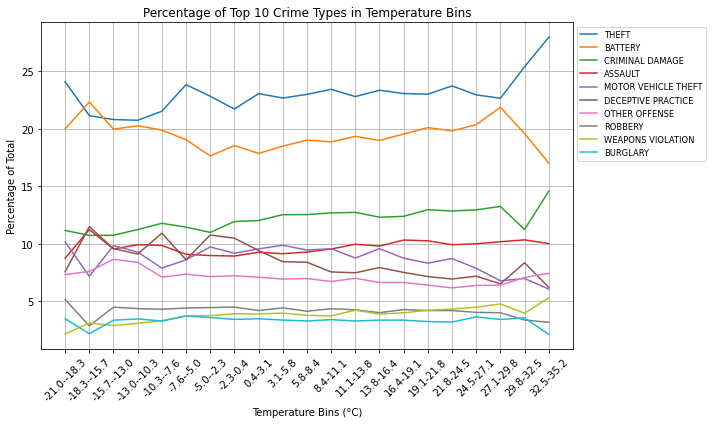

In [5]:
# create temperature bins
num_bins = 20
min_temp = joined_data.agg(F.min("temp")).collect()[0][0]
max_temp = joined_data.agg(F.max("temp")).collect()[0][0]
print(min_temp)
print(max_temp)
bin_size = (max_temp - min_temp) / num_bins

joined_data = joined_data.withColumn("temp_bin", 
                                     ((col("temp") - F.lit(min_temp)) / bin_size).cast("int"))

# group by temperature and type
grouped_data = joined_data.groupBy("temp_bin", "Primary Type").count()
pivot_data = grouped_data.groupBy("temp_bin").pivot("Primary Type").agg(F.first("count")).fillna(0)

# get top 10 crime types
crime_types = pivot_data.drop("temp_bin").columns
top_10_crime_types = sorted(crime_types, key=lambda x: pivot_data.agg({x: "sum"}).collect()[0][0], reverse=True)[:10]
pivot_data = pivot_data.select(["temp_bin"] + top_10_crime_types)

# prepare first plot that shows just counts
pivot_data = pivot_data.withColumn("temperature_bin_str", 
                                   F.concat(
                                       F.format_number((pivot_data["temp_bin"] * bin_size + F.lit(min_temp)), 1), 
                                       F.lit("-"), 
                                       F.format_number(((pivot_data["temp_bin"] + 1) * bin_size + F.lit(min_temp)), 1)))
pivot_data = pivot_data.orderBy("temp_bin")
pivot_data_pd = pivot_data.toPandas()
plt.figure(figsize=(10, 6))
for column in pivot_data_pd.columns:
    if column not in ['temp_bin', 'temperature_bin_str']:
        plt.plot(pivot_data_pd['temperature_bin_str'], pivot_data_pd[column], label=column)
plt.title('Frequency of Top 10 Crime Types in Temperature Bins')
plt.xlabel('Temperature Bins (°C)')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small') 
plt.grid(True)
plt.tight_layout()
plt.show()

# turn into percentages and make another plot
pivot_data = pivot_data.withColumn("total_count", sum(col(col_name) for col_name in top_10_crime_types))
for col_name in top_10_crime_types:
    pivot_data = pivot_data.withColumn(col_name, (col(col_name) / pivot_data["total_count"]) * 100)
pivot_data = pivot_data.drop("total_count")
pivot_data_pd = pivot_data.toPandas()
plt.figure(figsize=(10, 6))
for column in pivot_data.columns:
    if column not in ['temp_bin', 'temperature_bin_str']:
        plt.plot(pivot_data_pd['temperature_bin_str'], pivot_data_pd[column], label=column)
plt.title('Percentage of Top 10 Crime Types in Temperature Bins')
plt.xlabel('Temperature Bins (°C)')
plt.ylabel('Percentage of Total')
plt.xticks(rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small') 
plt.grid(True)
plt.tight_layout()
plt.show()

-21.0
32.5


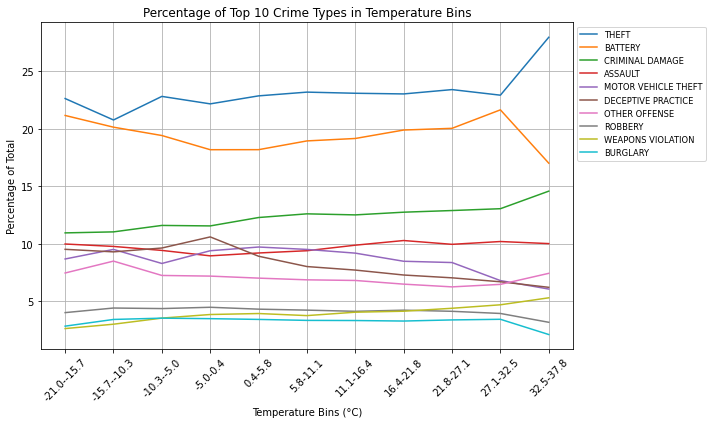

In [6]:
# create temperature bins
num_bins = 10
min_temp = joined_data.agg(F.min("temp")).collect()[0][0]
max_temp = joined_data.agg(F.max("temp")).collect()[0][0]
print(min_temp)
print(max_temp)
bin_size = (max_temp - min_temp) / num_bins

joined_data = joined_data.withColumn("temp_bin", 
                                     ((col("temp") - F.lit(min_temp)) / bin_size).cast("int"))

# group by temperature and type
grouped_data = joined_data.groupBy("temp_bin", "Primary Type").count()
pivot_data = grouped_data.groupBy("temp_bin").pivot("Primary Type").agg(F.first("count")).fillna(0)

# get top 10 crime types
crime_types = pivot_data.drop("temp_bin").columns
top_10_crime_types = sorted(crime_types, key=lambda x: pivot_data.agg({x: "sum"}).collect()[0][0], reverse=True)[:10]
pivot_data = pivot_data.select(["temp_bin"] + top_10_crime_types)

# normalise to 100% and make another plot
pivot_data = pivot_data.withColumn("temperature_bin_str", 
                                   F.concat(
                                       F.format_number((pivot_data["temp_bin"] * bin_size + F.lit(min_temp)), 1), 
                                       F.lit("-"), 
                                       F.format_number(((pivot_data["temp_bin"] + 1) * bin_size + F.lit(min_temp)), 1)))
pivot_data = pivot_data.orderBy("temp_bin")
pivot_data = pivot_data.withColumn("total_count", sum(col(col_name) for col_name in top_10_crime_types))
for col_name in top_10_crime_types:
    pivot_data = pivot_data.withColumn(col_name, (col(col_name) / pivot_data["total_count"]) * 100)
pivot_data = pivot_data.drop("total_count")
pivot_data_pd = pivot_data.toPandas()
plt.figure(figsize=(10, 6))
for column in pivot_data.columns:
    if column not in ['temp_bin', 'temperature_bin_str']:
        plt.plot(pivot_data_pd['temperature_bin_str'], pivot_data_pd[column], label=column)
plt.title('Percentage of Top 10 Crime Types in Temperature Bins')
plt.xlabel('Temperature Bins (°C)')
plt.ylabel('Percentage of Total')
plt.xticks(rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small') 
plt.grid(True)
plt.tight_layout()
plt.show()

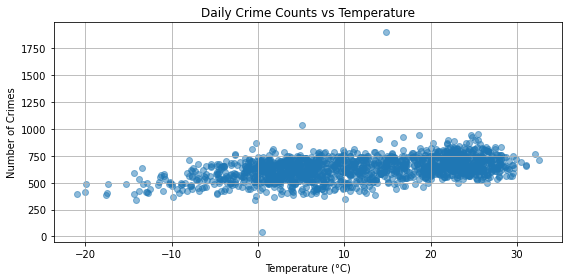

In [15]:

# group by date and temperature
daily_temperature_crime_counts = joined_data.groupBy('Date', 'temp').count()

# make the plot
daily_temperature_crime_counts_pd = daily_temperature_crime_counts.toPandas()
plt.figure(figsize=(8, 4))
plt.scatter(daily_temperature_crime_counts_pd['temp'], daily_temperature_crime_counts_pd['count'], alpha=0.5)
plt.title('Daily Crime Counts vs Temperature')
plt.xlabel('Temperature (°C)')
plt.ylabel('Number of Crimes')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import seaborn as sns

# split data based on yes snow and no snow
snow_0_data = joined_data.filter(joined_data['snow'] == 0)
snow_gt_0_data = joined_data.filter(joined_data['snow'] > 0)

# reclassify the < 3% crime types as other offense
threshold = 0.03
data = snow_0_data
crime_type_counts = data.groupBy('Primary Type').count()
total_crimes = crime_type_counts.agg(F.sum('count')).collect()[0][0]
threshold_count = total_crimes * threshold
insignificant_crime_types = crime_type_counts.filter(crime_type_counts['count'] < threshold_count)
insignificant_crime_types_list = [row['Primary Type'] for row in insignificant_crime_types.collect()]
data = data.withColumn('Primary Type', 
                       F.when(data['Primary Type'].isin(insignificant_crime_types_list), 
                              F.lit("OTHER OFFENSE")).otherwise(data['Primary Type']))
crime_type_counts = data.groupBy('Primary Type').count().orderBy('count', ascending=False)
snow_0_type_counts = crime_type_counts

data = snow_gt_0_data
crime_type_counts = data.groupBy('Primary Type').count()
total_crimes = crime_type_counts.agg(F.sum('count')).collect()[0][0]
threshold_count = total_crimes * threshold
insignificant_crime_types = crime_type_counts.filter(crime_type_counts['count'] < threshold_count)
insignificant_crime_types_list = [row['Primary Type'] for row in insignificant_crime_types.collect()]
data = data.withColumn('Primary Type', 
                       F.when(data['Primary Type'].isin(insignificant_crime_types_list), 
                              F.lit("OTHER OFFENSE")).otherwise(data['Primary Type']))
crime_type_counts = data.groupBy('Primary Type').count().orderBy('count', ascending=False)
snow_gt_0_type_counts = crime_type_counts

# make plot
snow_0_type_counts_pd = snow_0_type_counts.toPandas()
snow_gt_0_type_counts_pd = snow_gt_0_type_counts.toPandas()
palette = sns.color_palette('tab20', max(len(snow_0_type_counts_pd), len(snow_gt_0_type_counts_pd)))
fig, axes = plt.subplots(2, 1, figsize=(18, 9))
axes[0].pie(snow_0_type_counts_pd['count'], labels=snow_0_type_counts_pd['Primary Type'], autopct='%1.1f%%', startangle=140, colors=palette)
axes[0].set_title('Crime Types Distribution (Snow = 0 mm) (Percentage > 3% or Aggregated as "OTHER OFFENSE")')
axes[1].pie(snow_gt_0_type_counts_pd['count'], labels=snow_gt_0_type_counts_pd['Primary Type'], autopct='%1.1f%%', startangle=140, colors=palette)
axes[1].set_title('Crime Types Distribution (Snow > 0 mm) (Percentage > 3% or Aggregated as "OTHER OFFENSE")')
plt.tight_layout()
plt.show()
